<h1><h1>Pre-trained-Models with PyTorch </h1>

In this lab, we will use pre-trained models to classify between the negative and positive samples. The particular pre-trained model will be resnet18. ResNet18 is a 72-layer architecture with 18 deep layers. The architecture of this network aimed at enabling large amounts of convolutional layers to function efficiently.
We will have three parts: 
<ul>
<li>change the output layer</li>
<li> train the model</li> 
<li>  identify  several  misclassified samples</li> 
 </ul>


<h2>Table of Contents</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">


<ul>
    <li><a href="#download_data"> Download Data</a></li>
    <li><a href="#auxiliary"> Imports and Auxiliary Functions </a></li>
    <li><a href="#data_class"> Dataset Class</a></li>
    <li><a href="#Question_1">Question 1</a></li>
    <li><a href="#Question_2">Question 2</a></li>
    <li><a href="#Question_3">Question 3</a></li>
</ul>
    
 </div>
<hr>


<h2 id="download_data">Download Data</h2>


dataset link: 
    https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
    https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip

After downloaded the datasets, import and use **zipfile** to extract data to customed folder for later use. detail of zipfile usage can be founded in https://github.com/HungPham14/python_code/blob/main/python_note.ipynb notebook.

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use for this lab. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [1]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [2]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


In [3]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/PYTHON_CODE/data/resnet18_pytorch_project"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.


In [4]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


In [5]:
validation_dataset = Dataset(train=False)
print("done")

done


<h2 id="Question_1">Part 1</h2>


<b>Prepare a pre-trained resnet18 model :</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [7]:
# Step 1: Load the pre-trained model resnet18
model = models.resnet18(pretrained=True)

<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [8]:
# Step 2: Set the parameter cannot be trained for the pre-trained model
for param in model.parameters():
    param.requires_grad = False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [9]:
model.fc = nn.Linear(512,2)

In [12]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h2 id="Question_2">Part 2: Train the Model</h2>


<b>Step 1</b>: Create a cross entropy criterion function 


In [10]:
# Step 1: Create the loss function

criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.


In [11]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=100
)

validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset,
    batch_size=100
)

<b>Step 3</b>: Use the following optimizer to minimize the loss 


In [12]:
optimizer = torch.optim.Adam([parameters  for parameters in model.parameters() if parameters.requires_grad],lr=0.001)

<!--Empty Space for separating topics-->


**Complete the following code to calculate  the accuracy on the validation data for one epoch; this should take about 45 minutes.**


In [13]:
n_epochs=1
loss_list=[]
accuracy_list=[]
correct=0
N_test=len(validation_dataset)
N_train=len(train_dataset)

# Loss=0
start_time = time.time()
for epoch in range(n_epochs):
    for x, y in train_loader:
        model.train() 
        #clear gradient 
        optimizer.zero_grad()
        #make a prediction 
        z = model(x)
        # calculate loss 
        loss = criterion(z, y)
        # calculate gradients of parameters 
        loss.backward()
        # update parameters 
        optimizer.step()
        loss_list.append(loss.data)
    correct=0
    for x_test, y_test in validation_loader:
        # set model to eval 
        model.eval()
        #make a prediction 
        z = model(x_test)
        #find max 
        _, y_hat = torch.max(z.data,1)
        #Calculate misclassified  samples in mini-batch 
        #hint +=(yhat==y_test).sum().item()
        correct += (y_hat == y_test).sum().item()
   
    accuracy=correct/N_test
    accuracy_list.append(accuracy)
end_time = time.time()
print('initial run time: {0:.5f}'.format(end_time - start_time))

initial run time: 3956.82279


In [16]:
# save model for evaluation
FILE = 'resnet18_pytorch_trained_model.pth'
torch.save(model, FILE)

<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code> for every iteration and take a screen shot.</b>


In [25]:
accuracy

0.994

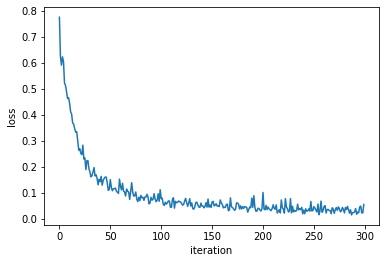

In [26]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


**As we can clearly see, ResNet18 model fitting time is quite satisfying with slightly above 1 hour and still produce 99.4% accuracy with good-result loss. In the next notebook, we will go through ResNet50 & VGG16 pretrained models.**

<h2 id="Question_3">Part 3:Find the misclassified samples</h2> 


<b>Identify the first four misclassified samples using the validation data:</b>


In [59]:
# Identify the first four misclassified samples using the validation data
# FILE = 'resnet18_pytorch_trained_model.pth'
# model = torch.load(FILE)
count = 0
i = 0
for x, y in validation_dataset:
    x = torch.unsqueeze(x, 0)
    model.eval()
    z = model(x)
    _, yhat = torch.max(z.data, 1)
    if yhat != y:
        i += 1
        print(f'sample {i} predicted value:{yhat} actual value:{torch.tensor([y])}')
        count += 1
    if yhat == y:
        i += 1
        continue
    if count >= 4:
        break                

sample 23 predicted value:tensor([0]) actual value:tensor([1])
sample 102 predicted value:tensor([1]) actual value:tensor([0])
sample 132 predicted value:tensor([1]) actual value:tensor([0])
sample 183 predicted value:tensor([0]) actual value:tensor([1])


## This is the end of this notebook. Thank you for reading til this part. 